In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import urllib.request, json
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import geopandas as gp
from shapely.geometry import Polygon, Point, MultiPoint, MultiPolygon
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy_utils import create_database, database_exists, drop_database
import jetson_configs as jcfg
import matplotlib
import copy

%matplotlib inline

In [2]:
first_month   = jcfg.first_month
current_month = jcfg.current_month

# Configure connection

In [3]:
#We supply our credentials and point to the database we're trying to connect to and
host     = jcfg.sql_host
user     = jcfg.sql_user
password = jcfg.sql_password
database = "jetson"

engine = create_engine(f'postgresql://{user}:{password}@{host}/{database}') 

In [4]:
# Load the SQL_magic extension and configure the connection
%reload_ext sql_magic
%config SQL.conn_name = 'engine'

# Get data

In [5]:
# Get list of regions
regions = ['Awdal', 'Bakool', 'Banadir', 'Bari', 'Bay', 'Galgaduud', 'Gedo',
           'Hiraan', 'Lower Juba', 'Lower Shabelle', 'Middle Juba',
           'Middle Shabelle', 'Mudug', 'Nugaal', 'Sool', 'Togdheer',
           'Woqooyi Galbeed', 'Sanaag']

## Import

In [6]:
somalia_map = gp.read_postgis('SELECT * FROM geo_admin1',   con=engine, geom_col='geometry')
prmn        = pd.read_sql(    f"SELECT * FROM monthly_prmn WHERE date>='{first_month}-01' AND date<='{current_month}-01'", con=engine, parse_dates=['date'])

## Clean

In [7]:
# Clean map
somalia_map['centroid_x'] = somalia_map.geometry.centroid.x
somalia_map['centroid_y'] = somalia_map.geometry.centroid.y

C:\Users\katherine\.conda\envs\py36\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
C:\Users\katherine\.conda\envs\py36\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
# Clean PRMN
prmn.sort_values(['date', 'arrival_region', 'previous_region'], inplace=True)
prmn.rename(columns = {'arrival_region' :'dest_region', 
                       'previous_region':'src_region',
                       'n'              :'arrivals'}, inplace=True)
prmn = prmn.groupby(['date', 'src_region', 'dest_region']).sum()

## Build OD

In [9]:
# Make network df
nx_df = prmn[prmn.index.get_level_values('src_region').isin(regions) & prmn.index.get_level_values('dest_region').isin(regions)]
nx_df = nx_df.unstack(level='dest_region').fillna(0).stack()
nx_df.reset_index(inplace=True)

In [10]:
number_of_months = len(nx_df.date.unique())

## Build other flow dataframes

In [11]:
# Estimate in, out, and internal flows
idp     = nx_df[nx_df.src_region==nx_df.dest_region][['src_region', 'dest_region','arrivals']].groupby('src_region').sum()
outflow = nx_df[nx_df.src_region!=nx_df.dest_region][['src_region', 'dest_region','arrivals']].groupby('src_region').sum()
inflow  = nx_df[nx_df.src_region!=nx_df.dest_region][['src_region', 'dest_region','arrivals']].groupby('dest_region').sum()

idp.columns    = ['internal']
outflow.columns= ['outflow']
inflow.columns = ['inflow']

all_flows = pd.concat([inflow, idp, outflow], axis=1, sort=True)

In [12]:
# Create normalized version of in, out, internal flows
all_flows_pct = all_flows.div(all_flows.sum(axis=1), axis=0)

In [13]:
# Create average arrivals over all months in dataset
avg_arrivals = nx_df[['src_region', 'dest_region','arrivals', 'date']]
#avg_arrivals['arrivals'] = avg_arrivals['arrivals'].replace(0, np.nan)
avg_arrivals = avg_arrivals.groupby(['date','dest_region']).sum().groupby('dest_region').mean()
avg_arrivals.columns=['avg_arrivals']

## Merge onto map

In [14]:
somalia_map = somalia_map.merge(avg_arrivals,  left_on="region", right_index=True)
somalia_map = somalia_map.merge(all_flows,     left_on="region", right_index=True)
somalia_map = somalia_map.merge(all_flows_pct, left_on="region", right_index=True, suffixes=["","_pct"])

# Network analysis

## Outflows and inflows

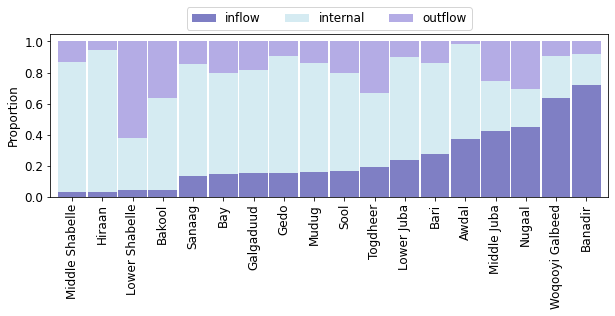

In [15]:
all_flows_pct.sort_values('inflow', inplace=True)

# Plot the distribution
ax = all_flows_pct.plot(kind='bar', stacked=True, width=.95, figsize=[10,3], 
                                                color = ['darkblue', 'lightblue', 'slateblue'], alpha=0.5, fontsize=12)

ax.legend(loc="upper center", ncol=3, bbox_to_anchor=[0.5,1.2], fontsize=12)
ax.set_xticklabels([i #.replace("Middle", "M.").replace("Lower", "L.").replace("Woqooyi", "Woq.").replace("Galbeed", "Galb.")  
                    for i in all_flows_pct.index], fontsize=12)
ax.set_ylabel("Proportion", fontsize=12)
plt.savefig("figures/in_out_wide.png", dpi=100, bbox_inches="tight")

In [16]:
# Make table of inflows/outflows/internal flows along with percent of missing observations
pct_missing = nx_df.groupby(['date', 'dest_region']).sum().replace(0, np.nan).isna().groupby(['dest_region']).sum() / len(nx_df.date.unique())

combined_table = all_flows_pct.merge(pct_missing, left_index=True, right_index=True).round(2).sort_index()


combined_table[['inflow', 'internal', 'outflow', 'arrivals']].to_latex("tables/combined_table.tex", header = ["Inflow poportion", 'Internal flow proportion', 'Outflow proportion', 'Proportion missing'], column_format = '|l|rrr|r|')

combined_table

,inflow,internal,outflow,arrivals
Awdal,0.37,0.61,0.02,0.05
Bakool,0.04,0.59,0.37,0.09
Banadir,0.72,0.20,0.08,0.00
Bari,0.28,0.58,0.14,0.09
Bay,0.14,0.65,0.20,0.02
Galgaduud,0.15,0.66,0.19,0.44
Gedo,0.16,0.75,0.09,0.01
Hiraan,0.03,0.91,0.06,0.36
Lower Juba,0.24,0.67,0.10,0.00
Lower Shabelle,0.04,0.34,0.62,0.02


## Source and sink regions

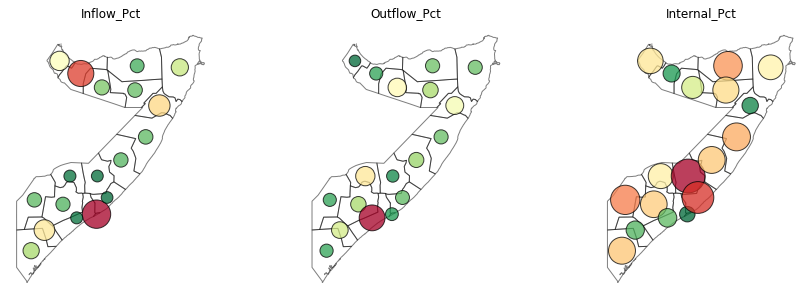

In [17]:
fig, ax = plt.subplots(1,3,figsize=[15,5])

cols =['inflow_pct', 'outflow_pct', 'internal_pct']

for a in [0,1,2]:
    somalia_map.plot(ax=ax[a], color="None", edgecolor="black", alpha=0.5)

    pd.DataFrame(somalia_map).plot(x='centroid_x', y='centroid_y', kind='scatter', edgecolor="black", alpha=0.75,
                                   c=(somalia_map[cols[a]]), s=((5+somalia_map[cols[a]]*6))**3, cmap='RdYlGn_r', colorbar=None,
                                   ax=ax[a])

    ax[a].axis("Off")
    ax[a].set_title(cols[a].title())
plt.show()

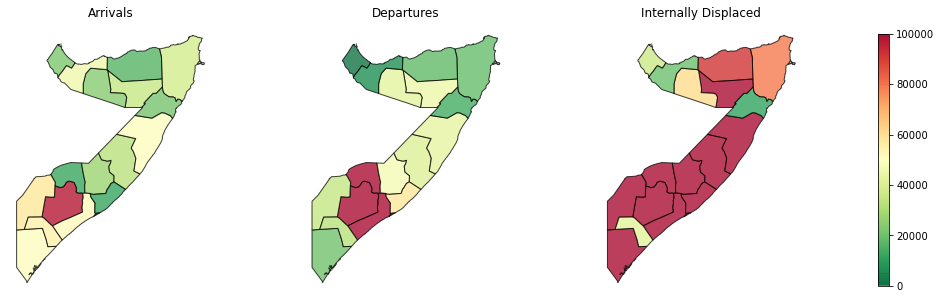

In [18]:
fig, ax = plt.subplots(1,3,figsize=[15,5])

#cols =['inflow_pct', 'outflow_pct', 'internal_pct']
cols   = ['inflow',   'outflow',    'internal']
labels = ['Arrivals', 'Departures', 'Internally Displaced']

for a in [0,1,2]:
    somalia_map.plot(cols[a], ax=ax[a], cmap='RdYlGn_r', vmin=0, vmax=100000, edgecolor='black', alpha=0.75)
    
    #nx.draw_networkx_labels(G, pos=shifted_pos, font_size=6, font_color="k", ax=ax[a]) #, font_weight='bold')

    ax[a].set_title(labels[a])
    
    ax[a].axis("Off")
    
im = plt.gca().get_children()[0]

    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)


## Pairwise flows

In [19]:
# Get average monthly flows
nx_df = nx_df.groupby(['src_region', 'dest_region']).mean().reset_index()

G = nx.from_pandas_edgelist(nx_df, source='src_region', target='dest_region', edge_attr='arrivals',
                           create_using=nx.DiGraph())

In [20]:
# Make the positions on the map
pos = {}
for i, row in somalia_map.iterrows():
    pos[row.region]= np.array([row.centroid_x, row.centroid_y])

## Inbound by region

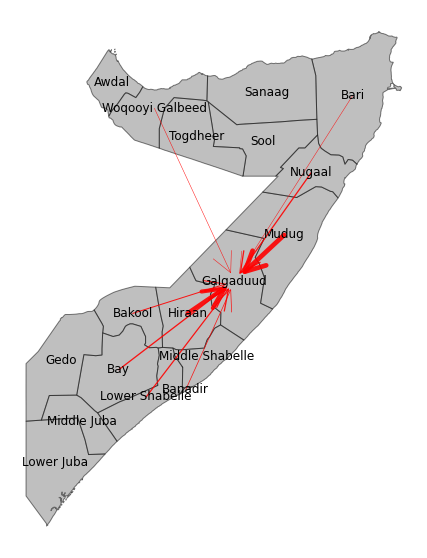

In [21]:
# Set the plot parameters
edgelist = [i for i in G.edges if i[1]=="Galgaduud"] #G.edges
weights = [G[i[0]][i[1]]['arrivals']**0.3 
           for i in edgelist]

colorpicker = {i: np.random.rand(3,1).flatten() for i in G.nodes}
colors =  [colorpicker[i[0]] for i in G.edges]


# Draw
fig, ax = plt.subplots(1,1,figsize=[10,10])
somalia_map.plot(ax=ax, color='grey', edgecolor="black", alpha=0.5)

#pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos=pos, edgelist = edgelist, width=weights, ax=ax, alpha=0.9, 
       node_color='None', edge_color='red', #colors, 
        with_arrows=True, arrowstyle='->', arrowsize=50)
nx.draw_networkx_labels(G, pos=pos, font_size=12) #, font_weight='bold')
plt.show()

## Outbound by region

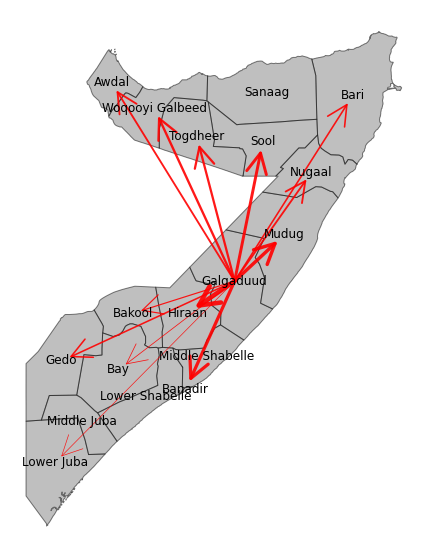

In [22]:
# Set the plot parameters
edgelist = [i for i in G.edges if i[0]=="Galgaduud"] #G.edges
weights = [G[i[0]][i[1]]['arrivals']**0.3 
           for i in edgelist]

colorpicker = {i: np.random.rand(3,1).flatten() for i in G.nodes}
colors =  [colorpicker[i[0]] for i in G.edges]


# Draw
fig, ax = plt.subplots(1,1,figsize=[10,10])
somalia_map.plot(ax=ax, color='grey', edgecolor="black", alpha=0.5)

#pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos=pos, edgelist = edgelist, width=weights, ax=ax, alpha=0.9, 
       node_color='None', edge_color='red', #colors, 
        with_arrows=True, arrowstyle='->', arrowsize=50)
nx.draw_networkx_labels(G, pos=pos, font_size=12) #, font_weight='bold')
plt.show()

# Major inflows

In [23]:
shifted_pos = pos.copy()

for k,v in shifted_pos.items():
    #shifted_pos[k][1]+=.3
    pass 

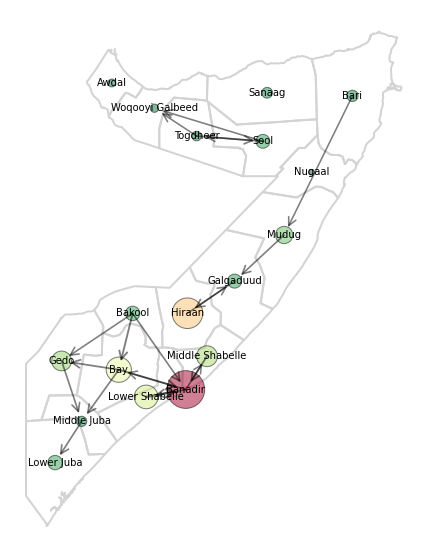

In [24]:
# Set the plot parameters
edgelist = [i for i in G.edges] #G.edges
weights = [G[i[0]][i[1]]['arrivals']**0.1 
           if  G[i[0]][i[1]]['arrivals']>=100 else 0
           for i in edgelist]

colorpicker = {i: np.random.rand(3,1).flatten() for i in G.nodes}
colors =  [colorpicker[i[0]] for i in G.edges]


# Draw
fig, ax = plt.subplots(1,1,figsize=[10,10])
somalia_map.plot(ax=ax, color='None', edgecolor="lightgrey", linewidth=2)

nx.draw(G, pos=pos, edgelist = edgelist, width=weights, ax=ax, alpha=0.5, 
       node_color='None', edge_color='black', #colors, 
        with_arrows=True, arrowstyle='->', arrowsize=20)
nx.draw_networkx_labels(G, pos=shifted_pos, font_size=10, font_color="k") #, font_weight='bold')


pd.DataFrame(somalia_map).plot(x='centroid_x', y='centroid_y', kind='scatter', edgecolor="black", alpha=0.5,
                               c=(somalia_map['avg_arrivals']), s=(somalia_map['avg_arrivals']/10)**1.05, cmap='RdYlGn_r', colorbar=None,
                               ax=ax)
#plt.savefig("figures/network.png", dpi=100, bbox_inches="tight")

In [25]:
# Fix the map labels
shifted_pos = copy.deepcopy(pos)

for k,v in shifted_pos.items():
    #shifted_pos[k][1]+=.3
    pass 

shifted_pos['Bari'][1] +=.2
shifted_pos['Togdheer'][1] -=.4
shifted_pos['Sool'][1] -=.3
shifted_pos['Bay'][1] +=.1
shifted_pos['Bakool'][1]  +=.2


shifted_pos['Nugaal'][0] +=.9
shifted_pos['Mudug'][0]  +=.9
shifted_pos['Middle Shabelle'][0]  +=1.5
shifted_pos['Banadir'][0]  +=.7

shifted_pos['Woqooyi Galbeed'][1]  -=.5
shifted_pos['Woqooyi Galbeed'][0]  -=1.5



shifted_pos['Galgaduud'][1]  +=.7
shifted_pos['Galgaduud'][0]  -=1.


shifted_pos['Lower Shabelle'][1] -=.5
shifted_pos['Lower Shabelle'][0] +=1


shifted_pos['Gedo'][1]  +=.2
shifted_pos['Gedo'][0]  -=.3


shifted_pos['Bay'][1]  +=.1
shifted_pos['Bay'][0]  +=.6

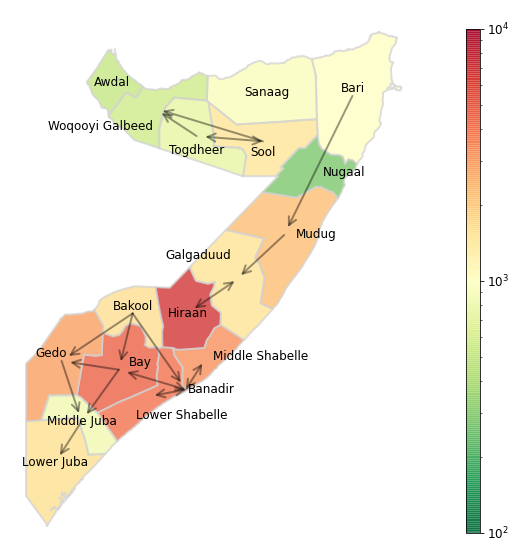

In [26]:
# Set the plot parameters
bidirected_edgelist = [i for i in G.edges if G[i[0]][i[1]]['arrivals']>=100 and G[i[1]][i[0]]['arrivals']>=100 and i[0]<i[1]]  # Last condition ensures that they're not duplicated or the same
oneway_edgelist     = [i for i in G.edges if G[i[0]][i[1]]['arrivals']>=100 and G[i[1]][i[0]]['arrivals']<100  and i[0]!=i[1]] # Last condition ensures that they're not the same

colorpicker = {i: np.random.rand(3,1).flatten() for i in G.nodes}
colors =  [colorpicker[i[0]] for i in G.edges]


# Draw
fig, ax = plt.subplots(1,1,figsize=[8,10])

# Arrivals heatmap
somalia_map.plot('avg_arrivals', ax=ax, cmap='RdYlGn_r', alpha=0.75, edgecolor='lightgrey', linewidth=2, norm=matplotlib.colors.LogNorm(vmin=100, vmax=10000))

# Flows
nx.draw(G, pos=pos, edgelist = bidirected_edgelist, width=2, ax=ax, alpha=0.4, 
       node_color='None', edge_color='black', #colors, 
        with_arrows=True, arrowstyle='<->', arrowsize=20)


nx.draw(G, pos=pos, edgelist = oneway_edgelist, width=2, ax=ax, alpha=0.4, 
       node_color='None', edge_color='black', #colors, 
        with_arrows=True, arrowstyle='->', arrowsize=20)

nx.draw_networkx_labels(G, pos=shifted_pos, font_size=12, font_color="k") #, font_weight='bold')

# Colorbar
im = plt.gca().get_children()[0]    
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.025, 0.7], )
fig.colorbar(im, cax=cbar_ax, norm=matplotlib.colors.LogNorm(vmin=100, vmax=10000))
cbar_ax.tick_params(labelsize=12)

plt.savefig("figures/network.png", dpi=100, bbox_inches="tight")

## Network layout

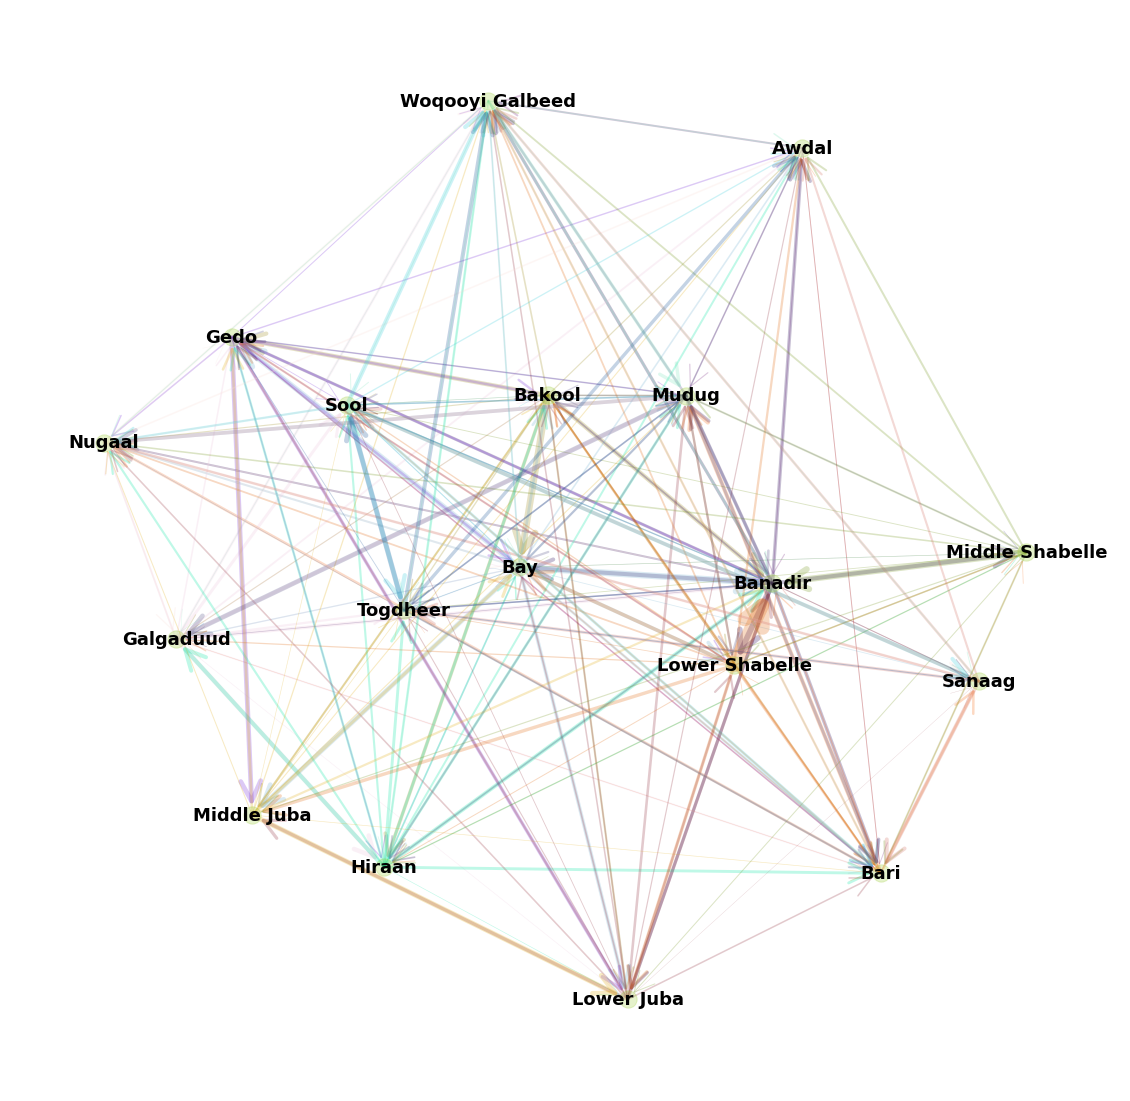

In [27]:
# Set the plot parameters
edgelist = G.edges
weights = [G[i[0]][i[1]]['arrivals']**0.3 for i in G.edges]

colorpicker = {i: np.random.rand(3,1).flatten() for i in G.nodes}
colors =  [colorpicker[i[0]] for i in G.edges]


# Draw
fig, ax = plt.subplots(1,1,figsize=[20,20])

pos = nx.spring_layout(G, weight='arrivals', k=8)
nx.draw(G, pos=pos, edgelist = edgelist, width=weights, ax=ax, alpha=0.25, 
       node_color='yellowgreen', edge_color=colors, with_arrows=True, arrowstyle='->', arrowsize=50)
nx.draw_networkx_labels(G, pos=pos, font_size=18, font_weight='bold')
plt.savefig("figures/network_spring.png", dpi=100, bbox_inches="tight")
plt.show()